# E-commerce Product Recommendation System

An E-commerce Product Recommendation System aims to enhance the shopping experience by suggesting products that are likely to interest customers based on their browsing and purchasing history. This system leverages machine learning algorithms to analyze customer behavior and predict their preferences.This project focuses on developing such a system that can seamlessly integrate into an existing e-commerce platform.

<img src="https://play-lh.googleusercontent.com/ademvbcTNw8tcwWMh0-ccwaHmtyc0zTiHnL4cc0En4xVNf90qHZTCfPCdPDslskt95np" 
alt="amazon" width="400" height="300">

## About the Dataset

The Amazon Beauty Product Reviews dataset, collected in 2023, is a rich repository of user-generated reviews for beauty products available on Amazon. 

|Field	|Type |	Explanation|
|-------|---- | -------------------------------------| 
|rating	|int|	Rating of the product (from 1 to 5).|
|title	|str	|Title of the user review.|
|text	|str	|Text body of the user review.|
|images	|str	|Images that users post after they have received the product.|
|asin	|str	|ID of the product.|
|parent_asin |	str	|Parent ID of the product.|
|user_id	|str	|ID of the reviewer|
|timestamp	|datetime	|Time of the review|
|helpful_vote	|int	|Helpful votes of the review|
|verified_purchase|	bool	|User purchase verification|


## Importing Libraries

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import warnings; warnings.simplefilter('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.decomposition import TruncatedSVD

from surprise.model_selection import train_test_split
from surprise import Dataset,Reader
from surprise import SVD, KNNWithMeans
from surprise import accuracy

### Load Dataset

You can download this dataset from Hugging Face. Here is the link: 'https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023'

In [12]:
#load data 
file_path = r"C:\Users\gunja\Downloads\All_Beauty.jsonl.gz"
# Read the JSON Lines file into a DataFrame
df = pd.read_json(file_path, lines=True)

## Data Wrangling

In [14]:
df.shape

(701528, 10)

In [15]:
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,True
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,True
2,5,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2,True
3,1,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,0,True
4,5,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,0,True


In [16]:
df.describe()

,rating,timestamp,helpful_vote
count,701528.000000,701528,701528.000000
mean,3.960245,2019-04-09 03:31:48.115045888,0.923588
min,1.000000,2000-11-01 04:24:18,0.000000
25%,3.000000,2017-08-01 19:39:25.777499904,0.000000
50%,5.000000,2019-10-20 18:11:28.616499968,0.000000
75%,5.000000,2021-03-02 01:05:05.557999872,1.000000
max,5.000000,2023-09-09 00:39:36.666000,646.000000
std,1.494452,NaN,5.471391


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             701528 non-null  int64         
 1   title              701528 non-null  object        
 2   text               701528 non-null  object        
 3   images             701528 non-null  object        
 4   asin               701528 non-null  object        
 5   parent_asin        701528 non-null  object        
 6   user_id            701528 non-null  object        
 7   timestamp          701528 non-null  datetime64[ns]
 8   helpful_vote       701528 non-null  int64         
 9   verified_purchase  701528 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 48.8+ MB


In [18]:
df.dtypes

rating                        int64
title                        object
text                         object
images                       object
asin                         object
parent_asin                  object
user_id                      object
timestamp            datetime64[ns]
helpful_vote                  int64
verified_purchase              bool
dtype: object

## Data Cleaning

In [20]:
df.drop(columns=['images', 'title', 'text', 'parent_asin', 'timestamp', 'helpful_vote', 'verified_purchase'], inplace=True)

In [21]:
df.rename(columns={'asin':'product_id'},inplace=True) #rename column

In [22]:
df.isnull().sum()

rating        0
product_id    0
user_id       0
dtype: int64

In [23]:
df.duplicated().sum()

7276

In [24]:
df=df.drop_duplicates()

In [25]:
df.shape

(694252, 3)

In [26]:
df.head()

,rating,product_id,user_id
0,5,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ
1,4,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ
2,5,B07PNNCSP9,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ
3,1,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ
4,5,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ


## Exploratory Data Analysis (EDA)

In [28]:
df.rating.unique() #unique values of column 'rating'

array([5, 4, 1, 3, 2], dtype=int64)

In [29]:
print("Total no of ratings :",df.shape[0]) #total number of ratings in the dataset
print("Total No of products  :", len(np.unique(df.product_id))) #total number of unique products in the dataset
print("Total No of users  :", len(np.unique(df.user_id))) #total number of unique users in the dataset

Total no of ratings : 694252
Total No of products  : 115709
Total No of users  : 631986


In [30]:
print('Minimum rating is: %d' %(df.rating.min()))
print('Maximum rating is: %d' %(df.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [31]:
# Count the number of users who gave a specific rating
for i in range(0,6): 
  print('Number of users who rated {0} ratings = {1}'.format(i, df[df['rating'] == i].shape[0]))

Number of users who rated 0 ratings = 0
Number of users who rated 1 ratings = 100888
Number of users who rated 2 ratings = 42601
Number of users who rated 3 ratings = 55720
Number of users who rated 4 ratings = 78608
Number of users who rated 5 ratings = 416435


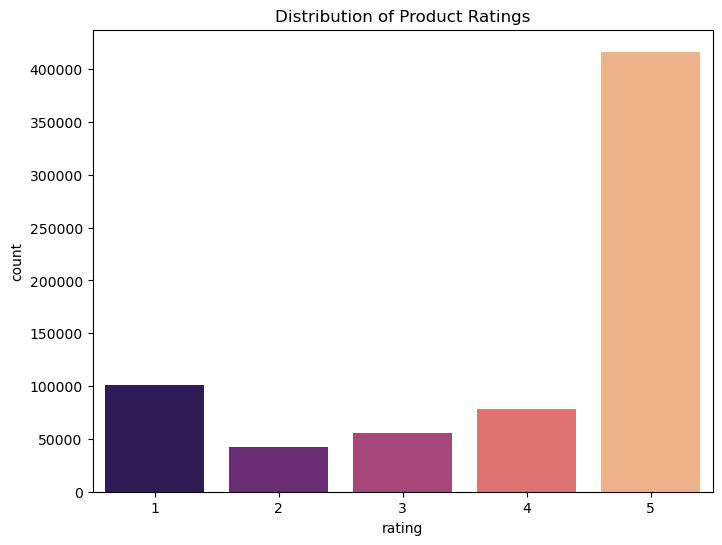

In [32]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='rating', palette='magma')
plt.title('Distribution of Product Ratings')
plt.show()

In [33]:
most_rated_products = df.groupby('product_id').size().sort_values(ascending=False).head(10).reset_index(name='count')
most_rated_products   #count the number of ratings for each product

,product_id,count
0,B007IAE5WY,1952
1,B00EEN2HCS,1726
2,B07C533XCW,1500
3,B00R1TAN7I,1362
4,B08L5KN7X4,1328
5,B019GBG0IE,1319
6,B0719KWG8H,1160
7,B0092MCQZ4,1123
8,B0107QYW14,1105
9,B0070Z7KME,923


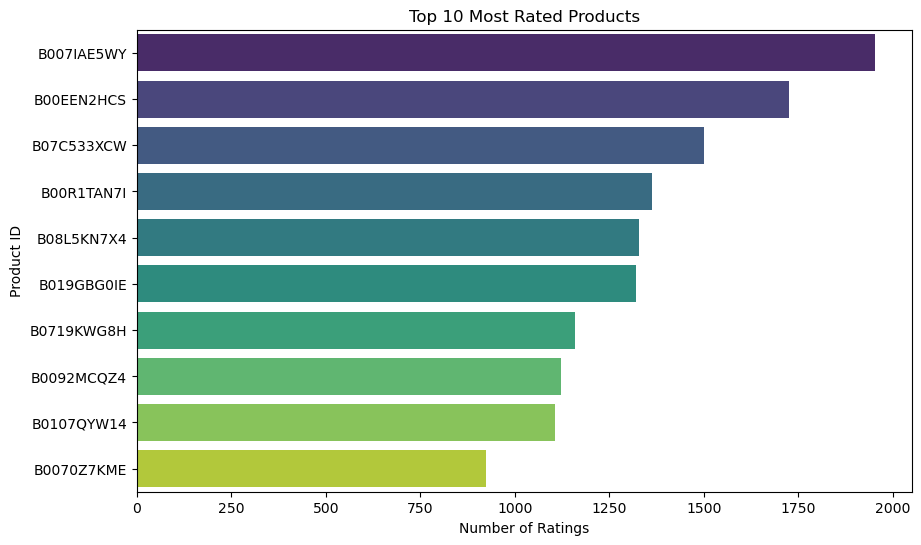

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='product_id', data=most_rated_products, palette='viridis')
plt.title('Top 10 Most Rated Products')
plt.ylabel('Product ID')
plt.xlabel('Number of Ratings')
plt.show()

In [35]:
most_rated_users = df.groupby('user_id').size().sort_values(ascending=False).head(10).reset_index(name='count')
most_rated_users  #count the number of ratings each user has given

,user_id,count
0,AG73BVBKUOH22USSFJA5ZWL7AKXA,165
1,AEZP6Z2C5AVQDZAJECQYZWQRNG3Q,146
2,AEMP3A7IKW37CMWFXNKXWW6HGJHA_1,115
3,AGZUJTI7A3JFKB4FP5JOH6NVAJIQ_1,87
4,AFDYIK3FNPY2JFBQYUWC6GSBMIRQ_2,83
5,AFXF3EGQTQDXMRLDWFU7UBFQZB7Q,81
6,AEJU3Z6HDAERETMYI2CXBQVPPDFA,79
7,AHY2TURQPNIDXZGH2CMQLZ343YMQ,69
8,AEOK4TQIKGO23SJKZ6PW4FETNNDA_1,68
9,AEAXAJACFMXIAAH4WOHRMXPSZWFA,65


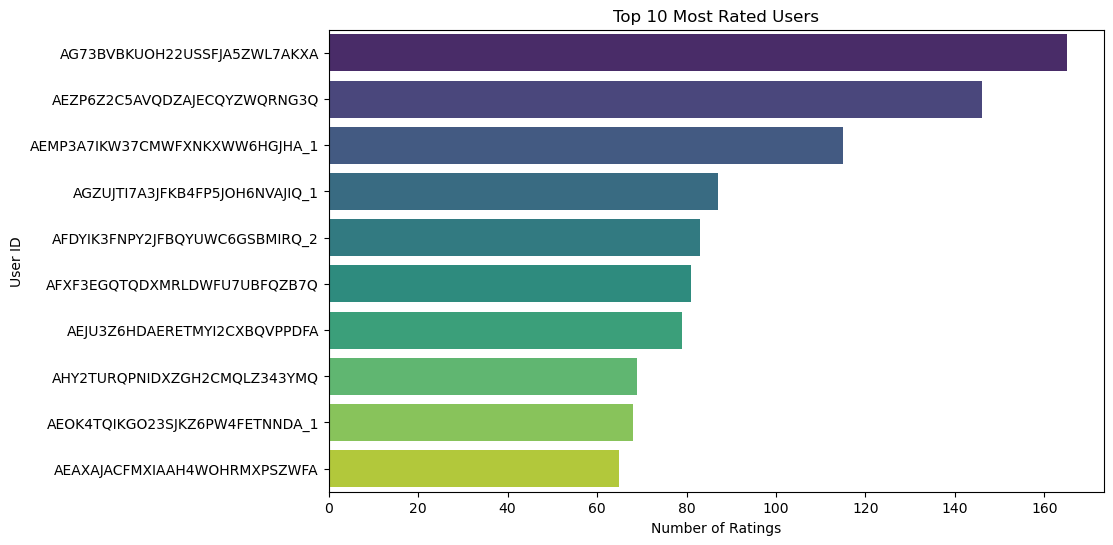

In [36]:
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='user_id', data=most_rated_users, palette='viridis')
plt.title('Top 10 Most Rated Users')
plt.ylabel('User ID')
plt.xlabel('Number of Ratings')
plt.show()

In [37]:
products_avg_rating=df.groupby('product_id')['rating'].mean().sort_values(ascending=False).head(10)
products_avg_rating  #average rating for each product

product_id
0005946468    5.0
B07GV5KVGF    5.0
B07GT9KTGK    5.0
B07GT9RJDP    5.0
B07GT9TBC2    5.0
B07GTFRFNN    5.0
B07GTG4Q3X    5.0
B07GTN43RQ    5.0
B07GTQTKPY    5.0
B07GTRNBWH    5.0
Name: rating, dtype: float64

In [38]:
ratings_mean_count = pd.DataFrame(df.groupby('product_id')['rating'].mean())  #average rating for each product
ratings_mean_count['rating_counts'] = pd.DataFrame(df.groupby('product_id')['rating'].count()) #count of ratings for each product
ratings_mean_count.head().sort_values(by='rating_counts', ascending=False)

,rating,rating_counts
product_id,,
0124784577,4.333333,3
0005946468,5.000000,1
0123034892,5.000000,1
0515059560,4.000000,1
0615675026,2.000000,1


Text(0.5, 1.0, 'Distribution of Average Ratings for Products')

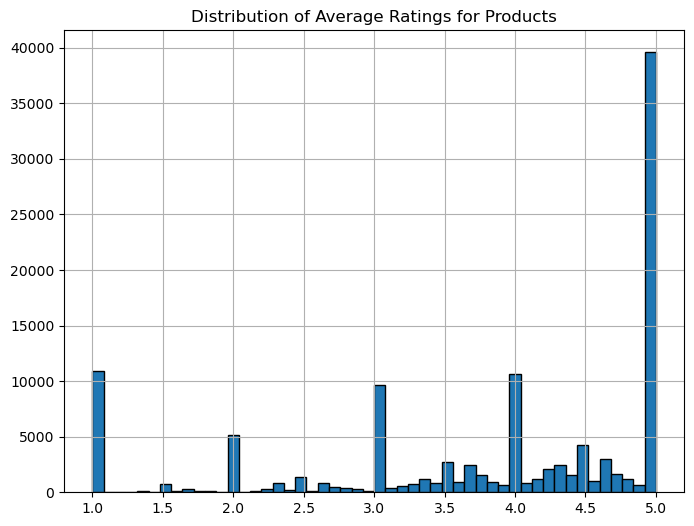

In [39]:
#histogram of the average ratings
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)
plt.title('Distribution of Average Ratings for Products')

### Take a subset of the dataset to make it less sparse/ denser

In [41]:
users_count = df.user_id.value_counts()
df_sample = df[df.user_id.isin(users_count[users_count >= 50].index)]
print('Number of users who has given 50 or more number of ratings =', len(df_sample))

Number of users who has given 50 or more number of ratings = 1479


In [42]:
#Number of unique user id and product id in the sample dataset
print('Number of unique USERS in sample dataset = ', df_sample['user_id'].nunique())
print('Number of unique PRODUCTS in sample dataset = ', df_sample['product_id'].nunique())

Number of unique USERS in sample dataset =  19
Number of unique PRODUCTS in sample dataset =  1121


### Creating a ratings matrix

In [44]:
ratings_matrix = df_sample.pivot(index = 'user_id', columns ='product_id', values = 'rating').fillna(0)
ratings_matrix.head()

product_id,B00018TN1S,B0002M5JNY,B0046BPTI2,B004UL6O2I,B005AL5H9S,B005HJHPCA,B0067BAIM6,B0085BEQX8,B009SNB978,B00BETY3EU,...,B0BBM276SL,B0BBY271B6,B0BCPHN1ZS,B0BF8YNJPS,B0BHQJDPGR,B0BMLD6TJY,B0BNJ2KVTP,B0BP67SKBN,B0BSR7H2MC,B0BVLF1PRL
user_id,,,,,,,,,,,,,,,,,,,,,
AEAXAJACFMXIAAH4WOHRMXPSZWFA,5.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEHWKRPNWNMOAJSMO2F6O7RFRTNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEJU3Z6HDAERETMYI2CXBQVPPDFA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
AEMP3A7IKW37CMWFXNKXWW6HGJHA_1,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEOK4TQIKGO23SJKZ6PW4FETNNDA_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
ratings_matrix.shape

(19, 1121)

In [46]:
ratings_matrix_T = ratings_matrix.transpose()  #Transposing the ratings matrix
ratings_matrix_T.head()

user_id,AEAXAJACFMXIAAH4WOHRMXPSZWFA,AEHWKRPNWNMOAJSMO2F6O7RFRTNA,AEJU3Z6HDAERETMYI2CXBQVPPDFA,AEMP3A7IKW37CMWFXNKXWW6HGJHA_1,AEOK4TQIKGO23SJKZ6PW4FETNNDA_1,AEZP6Z2C5AVQDZAJECQYZWQRNG3Q,AF2BLE54TEMGZ546U763ZHZRXC4A,AF2YKZQRMRGJ655I3MKQUYFGRQGA,AFDYIK3FNPY2JFBQYUWC6GSBMIRQ_1,AFDYIK3FNPY2JFBQYUWC6GSBMIRQ_2,AFXF3EGQTQDXMRLDWFU7UBFQZB7Q,AG73BVBKUOH22USSFJA5ZWL7AKXA,AGYVC7KVHP2AWM7BDCEYNHFA6F3Q,AGZUJTI7A3JFKB4FP5JOH6NVAJIQ_1,AH3BXW7KLIS2VAE56UXJS2NS7I5A,AHDVSLWHSORYGG3S5QZMVDFNOXUQ,AHGIDR4IJFS23Q4GTZ33FI5LYDSQ_1,AHPGHDFIU3BUB3RQBP56RQQA7W4Q,AHY2TURQPNIDXZGH2CMQLZ343YMQ
product_id,,,,,,,,,,,,,,,,,,,
B00018TN1S,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0002M5JNY,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0046BPTI2,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B004UL6O2I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B005AL5H9S,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
ratings_matrix_T.shape

(1121, 19)

In [48]:
#'user_index' is an index ranging from 0 to the number of users
ratings_matrix['user_index'] = np.arange(0, ratings_matrix.shape[0], 1)
ratings_matrix.set_index(['user_index'], inplace=True)
ratings_matrix.head()

product_id,B00018TN1S,B0002M5JNY,B0046BPTI2,B004UL6O2I,B005AL5H9S,B005HJHPCA,B0067BAIM6,B0085BEQX8,B009SNB978,B00BETY3EU,...,B0BBM276SL,B0BBY271B6,B0BCPHN1ZS,B0BF8YNJPS,B0BHQJDPGR,B0BMLD6TJY,B0BNJ2KVTP,B0BP67SKBN,B0BSR7H2MC,B0BVLF1PRL
user_index,,,,,,,,,,,,,,,,,,,,,
0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## User-Based Collaborative Filtering

Collaborative filtering is a popular technique used in recommendation systems to predict a user's preferences based on the preferences of other users.

##### Converted ratings matrix to a sparse CSR matrix

In [52]:
ratings_sparse = csr_matrix(ratings_matrix.values)

### Collaborative Filtering with Matrix Factorization (SVD)

In [54]:
U, sigma, Vt = svds(ratings_sparse, k = 10)

In [55]:
print('Left singular vector matrix: \n',U)

Left singular vector matrix: 
 [[-1.25098185e-01  2.69029602e-01  7.39653946e-03  9.08121721e-01
   7.86137674e-02 -8.10637806e-02  9.12647545e-02 -8.84777691e-02
  -2.90969510e-02  6.69754800e-02]
 [-3.18528144e-01  1.31230773e-02 -5.42982953e-01 -1.29940310e-01
   5.28667648e-01 -4.41645305e-01  4.78079780e-02 -5.01481428e-02
  -2.57836877e-01  5.02096496e-02]
 [-4.61062760e-02  2.87833611e-01  2.04032127e-01 -1.08076221e-01
   4.99930050e-01  6.20292037e-01 -1.70357127e-01 -1.83639153e-01
  -2.84265217e-01  5.37528798e-02]
 [-3.57267403e-02  9.02991789e-03 -9.63973965e-02 -1.07753153e-01
  -2.74278859e-01  1.74470275e-01  7.95615635e-01 -3.29814342e-01
  -3.38339821e-01  9.88004637e-02]
 [-2.64650480e-01  2.78821892e-02  3.40140662e-01  8.07101020e-02
  -2.92218418e-02 -9.51402588e-02  9.10347852e-02  1.15983949e-02
  -6.79803482e-02  9.32874087e-02]
 [-2.25199341e-02 -3.93918660e-02 -1.83683074e-02  3.22717453e-02
  -1.21082074e-01  1.00918371e-01 -1.10525752e-02  7.29477796e-01
  

In [56]:
print('Sigma: \n',sigma)

Sigma: 
 [36.12876484 36.9999034  37.35547514 38.62609708 39.64806053 40.80706714
 43.96349388 46.54037393 48.07111473 63.7316858 ]


As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [58]:
# Construct a diagonal matrix in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[36.12876484  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         36.9999034   0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         37.35547514  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         38.62609708  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         39.64806053  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         40.80706714
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  43.96349388  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         46.54037393  0.          0.        ]
 [ 0.          0.          0.        

In [59]:
print('Right singular vector matrix: \n',Vt)

Right singular vector matrix: 
 [[-0.01731282  0.09142409 -0.00124665 ...  0.01010688  0.00808931
  -0.00638083]
 [ 0.03635545  0.00720603 -0.0021293  ... -0.01419486  0.00844301
   0.03889654]
 [ 0.00099002 -0.02174937 -0.00098343 ...  0.00627011  0.00843243
   0.02730953]
 ...
 [-0.00950549 -0.00099954  0.03134817 ... -0.00495432 -0.00050582
  -0.01972902]
 [-0.00302645 -0.0008939  -0.01791531 ... -0.00337284 -0.00111046
  -0.02956715]
 [ 0.00525449  0.00914984  0.01543199 ...  0.00090246  0.00493157
   0.00421712]]


In [60]:
all_users_predict_ratings = np.dot(np.dot(U, sigma), Vt) 
# Predicted ratings
predict_ratings_df = pd.DataFrame(all_users_predict_ratings, columns = ratings_matrix.columns)
predict_ratings_df.head()

product_id,B00018TN1S,B0002M5JNY,B0046BPTI2,B004UL6O2I,B005AL5H9S,B005HJHPCA,B0067BAIM6,B0085BEQX8,B009SNB978,B00BETY3EU,...,B0BBM276SL,B0BBY271B6,B0BCPHN1ZS,B0BF8YNJPS,B0BHQJDPGR,B0BMLD6TJY,B0BNJ2KVTP,B0BP67SKBN,B0BSR7H2MC,B0BVLF1PRL
0,4.735038,0.020204,-0.032791,-0.083569,4.735038,-0.045589,-0.104461,4.735038,0.412026,-0.104461,...,-0.059219,-0.015320,0.024701,0.237192,0.296490,0.237192,-0.015320,0.237192,0.532791,-0.059219
1,0.091936,-0.295715,0.004921,0.042938,0.091936,0.012797,0.053673,0.091936,-0.173885,0.053673,...,-0.054368,-0.000230,0.302146,-0.212533,-0.265667,-0.212533,-0.000230,-0.212533,-0.108508,-0.054368
2,-0.059219,-0.140262,0.002584,-0.037820,-0.059219,-0.030785,-0.047276,-0.059219,0.041944,-0.047276,...,4.597084,-0.158890,0.981795,0.060867,0.076084,0.060867,-0.158890,0.060867,0.048243,4.597084
3,-0.045589,0.118326,-0.011100,-0.022058,-0.045589,4.969735,-0.027573,-0.045589,0.181374,-0.027573,...,-0.030785,-0.005612,0.077106,-0.046197,-0.057747,-0.046197,-0.005612,-0.046197,-0.037865,-0.030785
4,0.686711,-1.035910,0.155514,0.276479,0.686711,0.302289,0.345599,0.686711,0.674035,0.345599,...,0.069906,-0.044978,0.059494,-0.002349,-0.002936,-0.002349,-0.044978,-0.002349,0.133607,0.069906


In [61]:
# Recommend the items with the highest predicted ratings
def recommend_items(user_id, ratings_matrix, predict_ratings_df):
    # Index starts at 0
    user_idx = user_id-1
    # Get and sort the user's ratings
    sorted_user_ratings = ratings_matrix.iloc[user_idx].sort_values(ascending=False)
    # Sorted_user_ratings
    sorted_user_predictions = predict_ratings_df.iloc[user_idx].sort_values(ascending=False)
    # Sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(user_id))
    print(temp.head())

In [62]:
user_id = 5
recommend_items(user_id, ratings_matrix, predict_ratings_df)


Below are the recommended items for user(user_id = 5):

                   user_ratings  user_predictions
Recommended Items                                
B08F4ZDVZQ                  0.0          1.934847
B09MKLLL5J                  0.0          1.496860
B09Q5TTQS7                  0.0          1.496860
B07W1WJZFG                  0.0          1.343337
B087ZQK2G8                  0.0          1.256874


In [63]:
user_id = 10
recommend_items(user_id, ratings_matrix, predict_ratings_df)


Below are the recommended items for user(user_id = 10):

                   user_ratings  user_predictions
Recommended Items                                
B092MDX84M                  0.0          0.952152
B09DYL2V3R                  0.0          0.904507
B08NTD1NM1                  0.0          0.891690
B0BHQJDPGR                  0.0          0.836691
B08P27T7RZ                  0.0          0.836691


In [64]:
user_id = 15
recommend_items(user_id, ratings_matrix, predict_ratings_df)


Below are the recommended items for user(user_id = 15):

                   user_ratings  user_predictions
Recommended Items                                
B08F4ZDVZQ                  0.0          1.033847
B07W1WJZFG                  0.0          0.975839
B08BKWLHYP                  0.0          0.900416
B0868W34QW                  0.0          0.884570
B083BCSQGN                  0.0          0.882778


### Evaluate Model Performance

In [66]:
ratings_matrix.head()

product_id,B00018TN1S,B0002M5JNY,B0046BPTI2,B004UL6O2I,B005AL5H9S,B005HJHPCA,B0067BAIM6,B0085BEQX8,B009SNB978,B00BETY3EU,...,B0BBM276SL,B0BBY271B6,B0BCPHN1ZS,B0BF8YNJPS,B0BHQJDPGR,B0BMLD6TJY,B0BNJ2KVTP,B0BP67SKBN,B0BSR7H2MC,B0BVLF1PRL
user_index,,,,,,,,,,,,,,,,,,,,,
0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# Average ACTUAL rating for each item
ratings_matrix.mean().head()

product_id
B00018TN1S    0.263158
B0002M5JNY    0.263158
B0046BPTI2    0.105263
B004UL6O2I    0.210526
B005AL5H9S    0.263158
dtype: float64

In [68]:
# Predicted ratings 
predict_ratings_df.head()

product_id,B00018TN1S,B0002M5JNY,B0046BPTI2,B004UL6O2I,B005AL5H9S,B005HJHPCA,B0067BAIM6,B0085BEQX8,B009SNB978,B00BETY3EU,...,B0BBM276SL,B0BBY271B6,B0BCPHN1ZS,B0BF8YNJPS,B0BHQJDPGR,B0BMLD6TJY,B0BNJ2KVTP,B0BP67SKBN,B0BSR7H2MC,B0BVLF1PRL
0,4.735038,0.020204,-0.032791,-0.083569,4.735038,-0.045589,-0.104461,4.735038,0.412026,-0.104461,...,-0.059219,-0.015320,0.024701,0.237192,0.296490,0.237192,-0.015320,0.237192,0.532791,-0.059219
1,0.091936,-0.295715,0.004921,0.042938,0.091936,0.012797,0.053673,0.091936,-0.173885,0.053673,...,-0.054368,-0.000230,0.302146,-0.212533,-0.265667,-0.212533,-0.000230,-0.212533,-0.108508,-0.054368
2,-0.059219,-0.140262,0.002584,-0.037820,-0.059219,-0.030785,-0.047276,-0.059219,0.041944,-0.047276,...,4.597084,-0.158890,0.981795,0.060867,0.076084,0.060867,-0.158890,0.060867,0.048243,4.597084
3,-0.045589,0.118326,-0.011100,-0.022058,-0.045589,4.969735,-0.027573,-0.045589,0.181374,-0.027573,...,-0.030785,-0.005612,0.077106,-0.046197,-0.057747,-0.046197,-0.005612,-0.046197,-0.037865,-0.030785
4,0.686711,-1.035910,0.155514,0.276479,0.686711,0.302289,0.345599,0.686711,0.674035,0.345599,...,0.069906,-0.044978,0.059494,-0.002349,-0.002936,-0.002349,-0.044978,-0.002349,0.133607,0.069906


In [69]:
# Average PREDICTED rating for each item
predict_ratings_df.mean().head()

product_id
B00018TN1S    0.334725
B0002M5JNY    0.226342
B0046BPTI2    0.112441
B004UL6O2I    0.236373
B005AL5H9S    0.334725
dtype: float64

In [70]:
rmse_df = pd.concat([ratings_matrix.mean(), predict_ratings_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(1121, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
product_id,,,
B00018TN1S,0.263158,0.334725,0
B0002M5JNY,0.263158,0.226342,1
B0046BPTI2,0.105263,0.112441,2
B004UL6O2I,0.210526,0.236373,3
B005AL5H9S,0.263158,0.334725,4


In [71]:
RMSE = mean_squared_error(rmse_df.Avg_actual_ratings, rmse_df.Avg_predicted_ratings, squared=False)
print('\nRMSE of SVD Model = {} \n'.format(RMSE))


RMSE of SVD Model = 0.0988107449349306 



SVD model appears to be performing well with an RMSE of 0.0988, indicating accurate predictions relative to the rating scale.

## Item-Based Collaborative Filtering

In [74]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_sample[['user_id', 'product_id', 'rating']], reader)

In [75]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3, random_state=123)

### SVD

In [77]:
# Fit the model on Training set
svd_model = SVD(n_factors=10, biased=False)
svd_model.fit(trainset)

In [78]:
# Predict on Test set
svd_test_pred = svd_model.test(testset)
svd_test_pred

[Prediction(uid='AF2YKZQRMRGJ655I3MKQUYFGRQGA', iid='B08HQSGMJY', r_ui=5.0, est=1, details={'was_impossible': False}),
 Prediction(uid='AEAXAJACFMXIAAH4WOHRMXPSZWFA', iid='B08SWKD1WX', r_ui=5.0, est=4.314009661835748, details={'was_impossible': True, 'reason': 'User and item are unknown.'}),
 Prediction(uid='AHY2TURQPNIDXZGH2CMQLZ343YMQ', iid='B09DMFS6HX', r_ui=5.0, est=4.314009661835748, details={'was_impossible': True, 'reason': 'User and item are unknown.'}),
 Prediction(uid='AEZP6Z2C5AVQDZAJECQYZWQRNG3Q', iid='B081J2ZT7J', r_ui=5.0, est=4.314009661835748, details={'was_impossible': True, 'reason': 'User and item are unknown.'}),
 Prediction(uid='AHPGHDFIU3BUB3RQBP56RQQA7W4Q', iid='B093LVGJ9G', r_ui=5.0, est=4.314009661835748, details={'was_impossible': True, 'reason': 'User and item are unknown.'}),
 Prediction(uid='AEAXAJACFMXIAAH4WOHRMXPSZWFA', iid='B08VKQY815', r_ui=5.0, est=1.834848150573666, details={'was_impossible': False}),
 Prediction(uid='AFDYIK3FNPY2JFBQYUWC6GSBMIRQ_1', 

In [79]:
# Compute the RMSE of the model on the test set
rmse = accuracy.rmse(svd_test_pred, verbose=False) 
print(f"RMSE: {rmse}")

RMSE: 2.0299085858107797


 An RMSE of **2.0426** indicates that the model’s predictions are, on average, approximately **2.04** units away from the actual ratings. 

### KNNWithMeans

In [82]:
# Fit the model on Training set
knn_model = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
knn_model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [83]:
# Predict on Test set
knn_test_pred = knn_model.test(testset)
knn_test_pred

[Prediction(uid='AF2YKZQRMRGJ655I3MKQUYFGRQGA', iid='B08HQSGMJY', r_ui=5.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AEAXAJACFMXIAAH4WOHRMXPSZWFA', iid='B08SWKD1WX', r_ui=5.0, est=4.314009661835748, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AHY2TURQPNIDXZGH2CMQLZ343YMQ', iid='B09DMFS6HX', r_ui=5.0, est=4.314009661835748, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AEZP6Z2C5AVQDZAJECQYZWQRNG3Q', iid='B081J2ZT7J', r_ui=5.0, est=4.314009661835748, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AHPGHDFIU3BUB3RQBP56RQQA7W4Q', iid='B093LVGJ9G', r_ui=5.0, est=4.314009661835748, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AEAXAJACFMXIAAH4WOHRMXPSZWFA', iid='B08VKQY815', r_ui=5.0, est=4.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AFDYIK3FN

In [84]:
# Compute the RMSE of the model on the test set
rmse = accuracy.rmse(knn_test_pred, verbose=False) 
print(f"RMSE: {rmse}")

RMSE: 1.1288228638872044


An RMSE of **1.1288** indicates that the model’s predictions deviate from the actual ratings by about **1.13** units on average

#### Conclusion

The lower RMSE for KNNWithMeans translates to approximately **22.6%** of the rating scale, compared to about **40.85%** for the SVD model. This indicates that KNNWithMeans is more precise in its predictions.    
Based on the RMSE values, the KNNWithMeans model is currently the better choice for your recommendation system.

## Generating top 20 recommendations

In [89]:
uid = "AEAXAJACFMXIAAH4WOHRMXPSZWFA"  # raw user id 
iid = "B00018TN1S"  # raw item id 
# get a prediction for specific users and items.
pred = knn_model.predict(uid, iid, r_ui=0.0, verbose=True)

user: AEAXAJACFMXIAAH4WOHRMXPSZWFA item: B00018TN1S r_ui = 0.00   est = 5.00   {'actual_k': 1, 'was_impossible': False}


In [90]:
pred = pd.DataFrame(knn_test_pred)
top_20_recommendations=pred[pred['uid'] ==uid][['iid', 'r_ui','est']].sort_values(by = 'r_ui', ascending = False).head(20)
print("Top Recommendations for User:", uid)
print(top_20_recommendations)

Top Recommendations for User: AEAXAJACFMXIAAH4WOHRMXPSZWFA
            iid  r_ui      est
1    B08SWKD1WX   5.0  4.31401
5    B08VKQY815   5.0  4.00000
374  B07C64FR2F   5.0  4.31401
371  B08LPGZMQK   5.0  4.31401
365  B098X8XR24   5.0  4.31401
345  B07B7NTT8Z   5.0  4.31401
301  B07YNDMDZ6   5.0  4.31401
282  B08BG42L39   5.0  4.31401
279  B08JGL46K5   5.0  4.31401
248  B0085BEQX8   5.0  4.31401
185  B0977LVHF8   5.0  4.31401
183  B08WF29DM9   5.0  4.31401
134  B08K2K6RH8   5.0  5.00000
129  B08G4VWFNS   5.0  4.31401
123  B083BGJ4P9   5.0  5.00000
115  B0868W34QW   5.0  4.00000
83   B08VQY1Z1S   5.0  5.00000
76   B07YNDXQXB   5.0  4.31401
61   B09NXZJV2J   5.0  4.31401
378  B0752ZGG15   5.0  4.31401


## Model-based Collaborative Filtering

In [92]:
ratings_matrix.head()

product_id,B00018TN1S,B0002M5JNY,B0046BPTI2,B004UL6O2I,B005AL5H9S,B005HJHPCA,B0067BAIM6,B0085BEQX8,B009SNB978,B00BETY3EU,...,B0BBM276SL,B0BBY271B6,B0BCPHN1ZS,B0BF8YNJPS,B0BHQJDPGR,B0BMLD6TJY,B0BNJ2KVTP,B0BP67SKBN,B0BSR7H2MC,B0BVLF1PRL
user_index,,,,,,,,,,,,,,,,,,,,,
0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
ratings_matrix_T.head()

user_id,AEAXAJACFMXIAAH4WOHRMXPSZWFA,AEHWKRPNWNMOAJSMO2F6O7RFRTNA,AEJU3Z6HDAERETMYI2CXBQVPPDFA,AEMP3A7IKW37CMWFXNKXWW6HGJHA_1,AEOK4TQIKGO23SJKZ6PW4FETNNDA_1,AEZP6Z2C5AVQDZAJECQYZWQRNG3Q,AF2BLE54TEMGZ546U763ZHZRXC4A,AF2YKZQRMRGJ655I3MKQUYFGRQGA,AFDYIK3FNPY2JFBQYUWC6GSBMIRQ_1,AFDYIK3FNPY2JFBQYUWC6GSBMIRQ_2,AFXF3EGQTQDXMRLDWFU7UBFQZB7Q,AG73BVBKUOH22USSFJA5ZWL7AKXA,AGYVC7KVHP2AWM7BDCEYNHFA6F3Q,AGZUJTI7A3JFKB4FP5JOH6NVAJIQ_1,AH3BXW7KLIS2VAE56UXJS2NS7I5A,AHDVSLWHSORYGG3S5QZMVDFNOXUQ,AHGIDR4IJFS23Q4GTZ33FI5LYDSQ_1,AHPGHDFIU3BUB3RQBP56RQQA7W4Q,AHY2TURQPNIDXZGH2CMQLZ343YMQ
product_id,,,,,,,,,,,,,,,,,,,
B00018TN1S,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0002M5JNY,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0046BPTI2,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B004UL6O2I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B005AL5H9S,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
# Initialize TruncatedSVD with the desired number of components
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(ratings_matrix_T)  #Decomposing the Matrix
decomposed_matrix.shape

(1121, 10)

In [95]:
#Correlation Matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(1121, 1121)

In [96]:
ratings_matrix_T.index[100]

'B07HR754WV'

In [97]:
i = "B07HR754WV"

product_names = list(ratings_matrix_T.index)
product_ID = product_names.index(i)
product_ID

100

In [98]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(1121,)

## Generating Recommendations Based on Item Similarity

In [100]:
Recommend = list(ratings_matrix_T.index[correlation_product_ID > 0.65])
# Removes the item already bought by the customer
Recommend.remove(i) 
Recommend[0:20]

['B01BEYRHBA',
 'B01M24DUXH',
 'B01MFC2Q8C',
 'B071NBFSLY',
 'B073WQHFXB',
 'B077YR3333',
 'B07DPMFTLY',
 'B07DSC4X3K',
 'B07G23R7ZX',
 'B07HN1L8NQ',
 'B07KG1TWP5',
 'B07KXM94BT',
 'B07ND4HPHT',
 'B07Q1DC383',
 'B07QS62HVP',
 'B07S7G1WPT',
 'B081FYR22F',
 'B0823WPN5Q',
 'B0829HHW2M',
 'B082DXHTX8']

Here are the top 20 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.